In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 83.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [3]:
import os

os.chdir('/content/drive/MyDrive/srikaran')
os.getcwd()

'/content/drive/MyDrive/srikaran'

In [4]:
os.makedirs('/content/datasets')

In [5]:
import zipfile
import os

zip_path = '/content/drive/My Drive/srikaran/uw-madison-gi-tract-image-segmentation.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

zip_path = '/content/drive/My Drive/srikaran/coco.zip'
extract_path = '/content/datasets'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Unzipped successfully!")

Unzipped successfully!
Unzipped successfully!


In [6]:
import pycocotools
from pycocotools import mask
import pycocotools.mask as mask_util
import numpy as np
import json
from pycocotools.coco import COCO
from sklearn.model_selection import train_test_split
import random
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
import matplotlib as mpl
from tqdm import tqdm

def np_encoder(object):
    if isinstance(object, np.generic):
        return object.item()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from matplotlib.colors import ListedColormap
import segmentation_models_pytorch as smp

In [7]:
!ls /content/datasets/train/case90/case90_day0/scans

slice_0001_266_266_1.50_1.50.png  slice_0073_266_266_1.50_1.50.png
slice_0002_266_266_1.50_1.50.png  slice_0074_266_266_1.50_1.50.png
slice_0003_266_266_1.50_1.50.png  slice_0075_266_266_1.50_1.50.png
slice_0004_266_266_1.50_1.50.png  slice_0076_266_266_1.50_1.50.png
slice_0005_266_266_1.50_1.50.png  slice_0077_266_266_1.50_1.50.png
slice_0006_266_266_1.50_1.50.png  slice_0078_266_266_1.50_1.50.png
slice_0007_266_266_1.50_1.50.png  slice_0079_266_266_1.50_1.50.png
slice_0008_266_266_1.50_1.50.png  slice_0080_266_266_1.50_1.50.png
slice_0009_266_266_1.50_1.50.png  slice_0081_266_266_1.50_1.50.png
slice_0010_266_266_1.50_1.50.png  slice_0082_266_266_1.50_1.50.png
slice_0011_266_266_1.50_1.50.png  slice_0083_266_266_1.50_1.50.png
slice_0012_266_266_1.50_1.50.png  slice_0084_266_266_1.50_1.50.png
slice_0013_266_266_1.50_1.50.png  slice_0085_266_266_1.50_1.50.png
slice_0014_266_266_1.50_1.50.png  slice_0086_266_266_1.50_1.50.png
slice_0015_266_266_1.50_1.50.png  slice_0087_266_266_1.50_1.50

In [8]:
os.chdir('/content/drive/My Drive/srikaran/gi-tract-image-segmentation')
os.getcwd()

'/content/drive/My Drive/srikaran/gi-tract-image-segmentation'

In [9]:
from src.data import SegmentationDataset
from src.data import DataGenerator
from src.model import SimpleUNet
from src.loss import DiceLoss, ChannelwiseHausdorffDistanceLoss, CombinedLoss, IoU, AverageMeter
from src.utils.plot_utils import plot_masks, display_comparison

CLASSES = ['small_bowel', 'large_bowel', 'stomach']

In [10]:
train_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/train_json.json',
                                     shuffle=True)

val_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/val_json.json',
                                     shuffle=True)

test_generator_class = DataGenerator(dataset_dir='/content/datasets/train',
                                     subset="train",
                                     classes=CLASSES,
                                     input_image_size=(128,128),
                                     annFile='/content/datasets/coco/test_json.json',
                                     shuffle=False)

loading annotations into memory...
Done (t=1.23s)
creating index...
index created!
loading annotations into memory...
Done (t=0.20s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


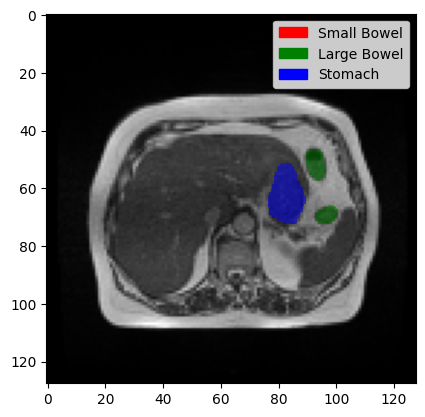

In [11]:
# Assuming X and y are loaded as mentioned
X, y = train_generator_class.__getitem__(10)

plot_masks(X, y)

In [12]:
train_loader = DataLoader(train_generator_class, batch_size=32, num_workers=0)
val_loader = DataLoader(val_generator_class, batch_size=32, num_workers=0)
test_loader = DataLoader(test_generator_class, batch_size=32, num_workers=0)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [15]:
model = smp.DeepLabV3Plus(
    encoder_name="resnext101_32x8d",   # Example of using a powerful ResNeXt model
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # can clip gradients here
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5, verbose=True, min_lr=0.001)
criterion = DiceLoss().to(device)

iou_criterion = IoU().to(device)

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth
100%|██████████| 340M/340M [00:04<00:00, 75.1MB/s]


In [16]:
# Training and validation loops
train_losses = []
train_iou_0 = [] # small bowel
train_iou_1 = [] # large bowel
train_iou_2 = [] # stomach

val_losses = []
val_iou_0 = []
val_iou_1 = []
val_iou_2 = []

epochs = 10

for epoch in range(epochs):
    model.train()
    train_loss_meter = AverageMeter()
    iou_meter_0 = AverageMeter()
    iou_meter_1 = AverageMeter()
    iou_meter_2 = AverageMeter()

    for data, target in tqdm(train_loader, desc=f'Epoch {epoch} Training'):
        data, target = data.to(device), target.to(device)
        data = data.permute(0, 3, 1, 2)
        target = target.permute(0, 3, 1, 2)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        train_loss_meter.update(loss.item(), data.size(0))
        iou_0, iou_1, iou_2 = iou_criterion(output, target)
        iou_meter_0.update(iou_0.item(), data.size(0))
        iou_meter_1.update(iou_1.item(), data.size(0))
        iou_meter_2.update(iou_2.item(), data.size(0))

    train_losses.append(train_loss_meter.avg)
    train_iou_0.append(iou_meter_0.avg)
    train_iou_1.append(iou_meter_1.avg)
    train_iou_2.append(iou_meter_2.avg)

    # Validation phase
    model.eval()
    val_loss_meter = AverageMeter()
    val_iou_meter_0 = AverageMeter()
    val_iou_meter_1 = AverageMeter()
    val_iou_meter_2 = AverageMeter()

    with torch.no_grad():
        for data, target in tqdm(val_loader, desc=f'Epoch {epoch} Validation'):
            data, target = data.to(device), target.to(device)
            data = data.permute(0, 3, 1, 2)
            target = target.permute(0, 3, 1, 2)
            output = model(data)
            loss = criterion(output, target)

            val_loss_meter.update(loss.item(), data.size(0))
            iou_0, iou_1, iou_2 = iou_criterion(output, target)
            val_iou_meter_0.update(iou_0.item(), data.size(0))
            val_iou_meter_1.update(iou_1.item(), data.size(0))
            val_iou_meter_2.update(iou_2.item(), data.size(0))

    val_losses.append(val_loss_meter.avg)
    val_iou_0.append(val_iou_meter_0.avg)
    val_iou_1.append(val_iou_meter_1.avg)
    val_iou_2.append(val_iou_meter_2.avg)

    scheduler.step(val_loss_meter.avg)
    print(f'Epoch {epoch}: Train Loss: {train_loss_meter.avg:.4f}, Val Loss: {val_loss_meter.avg:.4f}, \n \
            Train IOU SB: {iou_meter_0.avg:.4f}, Val IOU SB: {val_iou_meter_0.avg:.4f}, \n \
            Train IOU LB: {iou_meter_1.avg:.4f}, Val IOU LB: {val_iou_meter_1.avg:.4f}, \n \
            Train IOU S: {iou_meter_2.avg:.4f}, Val IOU S: {val_iou_meter_2.avg:.4f}')
    # Save model checkpoint
    torch.save(model.state_dict(), f'DeepLab_model_epoch_{epoch}.pth')


Epoch 0 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.15it/s]


Epoch 0: Train Loss: 0.4237, Val Loss: 0.4287, 
             Train IOU SB: 0.2420, Val IOU SB: 0.3312, 
             Train IOU LB: 0.4186, Val IOU LB: 0.5008, 
             Train IOU S: 0.4023, Val IOU S: 0.5326


Epoch 1 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.18it/s]


Epoch 1: Train Loss: 0.1992, Val Loss: 0.4765, 
             Train IOU SB: 0.3521, Val IOU SB: 0.2406, 
             Train IOU LB: 0.5824, Val IOU LB: 0.4607, 
             Train IOU S: 0.6002, Val IOU S: 0.4760


Epoch 2 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.17it/s]


Epoch 2: Train Loss: 0.1551, Val Loss: 0.3560, 
             Train IOU SB: 0.3889, Val IOU SB: 0.3319, 
             Train IOU LB: 0.6236, Val IOU LB: 0.5965, 
             Train IOU S: 0.6545, Val IOU S: 0.5938


Epoch 3 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.22it/s]


Epoch 3: Train Loss: 0.1301, Val Loss: 0.3474, 
             Train IOU SB: 0.4120, Val IOU SB: 0.3689, 
             Train IOU LB: 0.6522, Val IOU LB: 0.6042, 
             Train IOU S: 0.6805, Val IOU S: 0.6124


Epoch 4 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.15it/s]


Epoch 4: Train Loss: 0.1116, Val Loss: 0.3952, 
             Train IOU SB: 0.4299, Val IOU SB: 0.2752, 
             Train IOU LB: 0.6715, Val IOU LB: 0.5373, 
             Train IOU S: 0.7016, Val IOU S: 0.5701


Epoch 5 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.19it/s]


Epoch 5: Train Loss: 0.0983, Val Loss: 0.3559, 
             Train IOU SB: 0.4448, Val IOU SB: 0.2721, 
             Train IOU LB: 0.6846, Val IOU LB: 0.5892, 
             Train IOU S: 0.7141, Val IOU S: 0.6217


Epoch 6 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.20it/s]


Epoch 6: Train Loss: 0.0884, Val Loss: 0.3708, 
             Train IOU SB: 0.4525, Val IOU SB: 0.3321, 
             Train IOU LB: 0.6953, Val IOU LB: 0.5495, 
             Train IOU S: 0.7250, Val IOU S: 0.6144


Epoch 7 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.22it/s]


Epoch 7: Train Loss: 0.0778, Val Loss: 0.3472, 
             Train IOU SB: 0.4616, Val IOU SB: 0.2894, 
             Train IOU LB: 0.7052, Val IOU LB: 0.6203, 
             Train IOU S: 0.7365, Val IOU S: 0.6167


Epoch 8 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.23it/s]


Epoch 8: Train Loss: 0.0741, Val Loss: 0.3781, 
             Train IOU SB: 0.4665, Val IOU SB: 0.3155, 
             Train IOU LB: 0.7097, Val IOU LB: 0.5966, 
             Train IOU S: 0.7398, Val IOU S: 0.5626


Epoch 9 Validation: 100%|██████████| 145/145 [00:20<00:00,  7.19it/s]


Epoch 9: Train Loss: 0.0696, Val Loss: 0.3894, 
             Train IOU SB: 0.4677, Val IOU SB: 0.3612, 
             Train IOU LB: 0.7139, Val IOU LB: 0.5718, 
             Train IOU S: 0.7428, Val IOU S: 0.5164


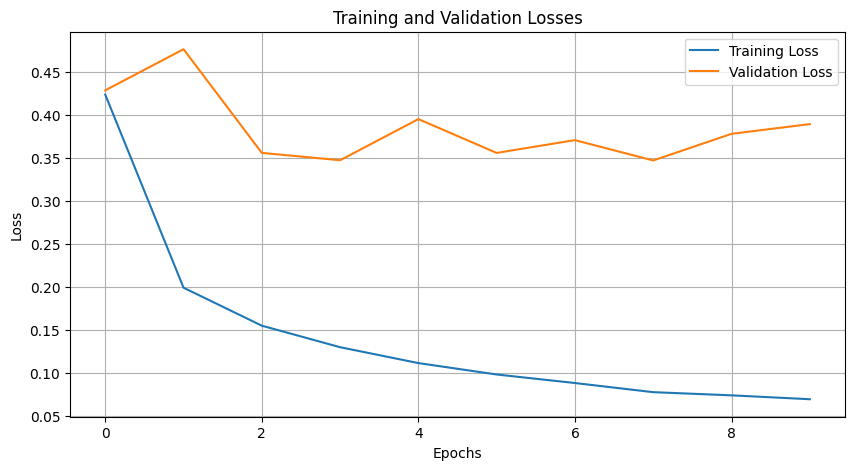

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
model = smp.DeepLabV3Plus(
    encoder_name="resnext101_32x8d",   # Example of using a powerful ResNeXt model
    encoder_weights="imagenet",
    in_channels=3,
    classes=3,
    activation='sigmoid'
).to(device)

# Load the saved model weights
model.load_state_dict(torch.load('DeepLab_model_epoch_3.pth'))

# Set the model to evaluation mode if you are making predictions
model.eval()

DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downs

In [20]:
images_test = []
predictions = []
masks = []

test_iou_meter_0 = AverageMeter()
test_iou_meter_1 = AverageMeter()
test_iou_meter_2 = AverageMeter()
test_dice_loss_meter = AverageMeter()

# No need to track gradients here
with torch.no_grad():
    for data in test_loader:
        # Assuming your DataLoader returns a tuple of (images, labels)
        images = data[0]
        images = images.permute(0, 3, 1, 2).to(device)
        images_test.append(images)

        # print(images.shape)
        # Generate predictions
        output = model(images)
        predictions.append(output)
        # print(output.shape)

        mask = data[1].permute(0, 3, 1, 2).to(device)
        masks.append(mask)
        # print(mask.shape)

        dice_loss = criterion(output, mask)
        iou_value0, iou_value1, iou_value2 = iou_criterion(output, mask)

        test_dice_loss_meter.update(dice_loss.item(), output.size(0))
        test_iou_meter_0.update(iou_value0.item(), output.size(0))
        test_iou_meter_1.update(iou_value1.item(), output.size(0))
        test_iou_meter_2.update(iou_value2.item(), output.size(0))


print(f'Test Dice Loss: {test_dice_loss_meter.avg:.4f}, \n \
        IOU for SB: {test_iou_meter_0.avg: .4f}, \n \
        IOU for LB: {test_iou_meter_1.avg: .4f}, \n \
        IOU for S: {test_iou_meter_2.avg: .4f}')

Test Dice Loss: 0.3372, 
         IOU for SB:  0.3724, 
         IOU for LB:  0.6064, 
         IOU for S:  0.6087


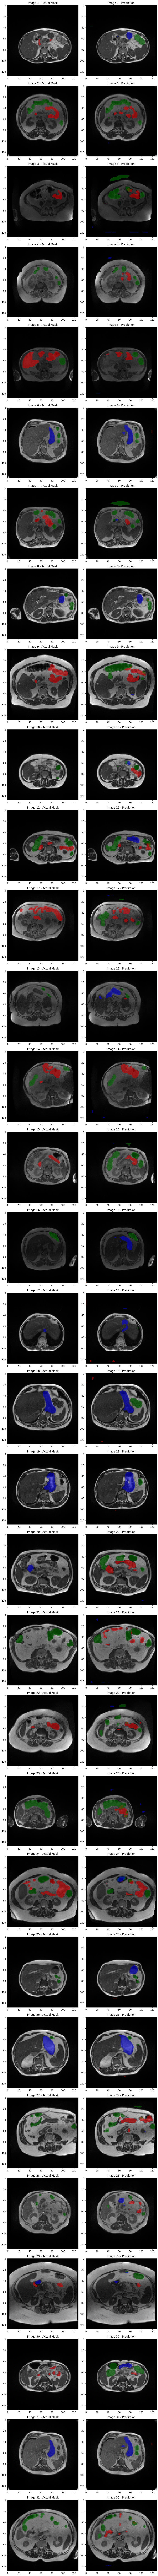

In [21]:
img_s = images_test[0]
pred_s = predictions[0]
mask_s = masks[0]

display_comparison(img_s.cpu().numpy(), pred_s.cpu().numpy(), mask_s.cpu().numpy())